# Feature Exploration

Goal: investigate each of the relevant features and conduct tests for significance between the relevant groups.

This is the notebook for the data with a true and misleading source articles in combination.

In [3]:
import pandas as pd
import os
import numpy as np
from dotenv import load_dotenv
import ast
import glob
import pingouin as pg

load_dotenv()

data_folder = os.getenv("DATA_FOLDER")

file_prefix = 'label_data'
file_prefix_true = 'true_label_data'

# Use glob to find all CSV files with the given filename start
file_list = glob.glob(f"{data_folder}/{file_prefix}*.csv")
file_list.extend(glob.glob(f"{data_folder}/{file_prefix_true}*.csv"))


# Read each file into a DataFrame and concatenate them into a single DataFrame
dataframes = [pd.read_csv(file, sep=";",index_col=0) for file in file_list]
df = pd.concat(dataframes, ignore_index=True)

Testing for faulty labels

In [4]:
faulty_labels = 0
def safe_literal_eval(x):
    global faulty_labels
    try:
        return ast.literal_eval(x)
    except:
        faulty_labels += 1

df['Labels'] = df['Labels'].apply(safe_literal_eval)
print(faulty_labels)

101


## Statistical Analysis of NewsGuard scores (before Transformation)

In [5]:
df = df[df['Category'] != 'Coul']

In [6]:
df.groupby('Category')['avg_score'].describe() 

,count,mean,std,min,25%,50%,75%,max
Category,,,,,,,,
True,97.0,85.844064,10.736738,35.000000,86.500000,87.65,90.900000,100.0
Misl,502.0,86.986136,14.181136,15.555556,85.635417,92.00,95.000000,100.0
True,802.0,86.940579,14.470597,5.000000,86.159375,91.00,94.427083,100.0


In [7]:
pg.normality(data=df, dv='avg_score', group='Category') #not normally distributed
pg.mwu(x=df.loc[df['Category'] == 'Misl', 'avg_score'],
                y=df.loc[df['Category'] == 'True', 'avg_score'],
                alternative='greater') #Mann-Whitney U (testing if Misl (Group 1) is higher than True (Group 2) -> differences statistically significant, but with a small effect size (RBC < 0.3)

,U-val,alternative,p-val,RBC,CLES
MWU,210354.0,greater,0.085656,0.044967,0.522484


Rerunning the analysis for only the non-NaN label values

In [8]:
df = df[df['Labels'].notna()]

In [9]:
df.groupby('Category')['avg_score'].describe() 

,count,mean,std,min,25%,50%,75%,max
Category,,,,,,,,
True,97.0,85.844064,10.736738,35.000000,86.500000,87.650000,90.90,100.0
Misl,450.0,87.057651,13.912862,15.555556,86.143939,91.972222,95.00,100.0
True,773.0,87.664959,13.009373,5.000000,86.400000,91.125000,94.45,100.0


In [10]:
pg.normality(data=df, dv='avg_score', group='Category') #not normally distributed
pg.mwu(x=df.loc[df['Category'] == 'Misl', 'avg_score'],
                y=df.loc[df['Category'] == 'True', 'avg_score'],
                alternative='greater') #Mann-Whitney U (testing if Misl (Group 1) is higher than True (Group 2) -> differences statistically significant, but with a small effect size (RBC < 0.3)

,U-val,alternative,p-val,RBC,CLES
MWU,179308.0,greater,0.183086,0.03095,0.515475


In [11]:
# placeholder_ng_score = df['avg_score'].median()
# placeholder_ng_score

## Feature Extraction

This is the main function for extracting and calculating the features for analysis.

In [12]:
def retrieve_params(label_dict_list, positions=False, headlines=False):
    #create three distinct lists to control each parameter
    # if label_dict_list is empty return NaN
    if not label_dict_list:
        return np.nan
    article_stances = []
    article_ng_scores = []
    article_serp_positions = []
    
    for article in label_dict_list: #this is the search level; here we can retrieve SERP position and Newsguard score
        if not article: #catch empty entries
            continue
        if len(article['comparisons']) == 0:
               continue
        #retrieve variables
        serp_newsguard = article['serp_newsguard']
        serp_position = article['serp_position']

        #add to lists for decomposed calculation
        article_ng_scores.append(serp_newsguard)
        article_serp_positions.append(serp_position)

        article_stance = 0
        for claim_pair in article['comparisons']: #this is the "article level"; here we can retrieve relative claim position and the bool headline info
            relation = claim_pair['relation']

            if relation == 0: #skip calculation logic for unrelated claims
                continue

            try:
                #retrieve relative claim positions
                fm_claim_position = claim_pair['fm_claim_position']
                serp_claim_position = claim_pair['serp_claim_position']

                #retrieve headline bool
                fm_claim_headline = claim_pair['fm_claim_headline']
                serp_claim_headline = claim_pair['serp_claim_headline']

            except:
                pass

            if not positions and not headlines: #calculate article stance only based on relation
                article_stance += relation
            if positions and not headlines: #calculate article stance based on relation and position
                if relation in [-1, 1]:
                    if serp_claim_position < fm_claim_position: #if serp claim earlier in the article than the respective fm claim
                        article_stance += relation + (serp_claim_position - fm_claim_position) if relation == -1 else relation - (serp_claim_position - fm_claim_position) #e.g. -1 - dif else 1 + dif (reinforcing in each direction)
                    else: # if serp claim later in article than the respective fm claim
                        article_stance += relation - (fm_claim_position - serp_claim_position) if relation == -1 else relation + (fm_claim_position - serp_claim_position) #e.g. - 1 + dif else 1 - dif (weakening in each direction)
            if positions and headlines:
                if relation in [-1, 1]:
                    individual_stance = 0
                    if serp_claim_position < fm_claim_position: #if serp claim earlier in the article than the respective fm claim
                        individual_stance = relation + (serp_claim_position - fm_claim_position) if relation == -1 else relation - (serp_claim_position - fm_claim_position) #e.g. -1 - dif else 1 + dif (reinforcing in each direction)
                        if serp_claim_headline:
                            individual_stance *= 2
                    else: # if serp claim later in article than the respective fm claim
                        individual_stance = relation - (fm_claim_position - serp_claim_position) if relation == -1 else relation + (fm_claim_position - serp_claim_position) #e.g. - 1 + dif else 1 - dif (weakening in each direction)
                        if serp_claim_headline:
                                individual_stance *= 2
                    article_stance += individual_stance
            if headlines and not positions:
                article_stance += relation * serp_claim_headline 
        if headlines and not positions:
            article_stances.append(article_stance/len(article['comparisons']))
        else:
            article_stances.append(article_stance/len(article['comparisons']))

    #if article_stances could not be successfully retrieved, return NaN
    if not article_stances:
        return np.nan
    
    article_ng_scores = np.array(article_ng_scores, dtype=float)
    # article_ng_scores = np.nan_to_num(article_ng_scores, nan=placeholder_ng_score) 

    return {'article_stances': article_stances, 'article_ng_scores': article_ng_scores, 'article_serp_positions': article_serp_positions}

Extracting the features based on different configs

In [13]:
df['Features_Raw']= df['Labels'].apply(retrieve_params)
df['Features_Pos']= df['Labels'].apply(lambda x: retrieve_params(x, positions=True, headlines=False))
df['Features_H']= df['Labels'].apply(lambda x: retrieve_params(x, positions=False, headlines=True))
df['Features_HP']= df['Labels'].apply(lambda x: retrieve_params(x, positions=True, headlines=True))

In [14]:
df = df[df['Features_Raw'].notna()]

In [15]:
df

,Article_day,ResponseId,Day,Category,True_Dummy,Seven_Ordinal,Four_Ordinal,Age,Gender,FC_Eval,...,avg_score,list_domains,list_scores,all_clean_urls,newsguard_dict,Labels,Features_Raw,Features_Pos,Features_H,Features_HP
1,Day_1_1,R_1Gv8iAs1HEqGuUe,Day_1,Misl,0,1,1,35,1,FM,...,95.277778,"abc15.com', 'salon.com', 'cnn.com', 'politico....","100,87.5,87.5,100,95,95,100,100,92.5",('https://www.abc15.com/news/state/poll-many-r...,"{'abc15.com': 100, 'salon.com': 87.5, 'cnn.com...","[{}, {}, {}, {}, {}, {}, {}, {}, {}, {'compari...","{'article_stances': [0.0], 'article_ng_scores'...","{'article_stances': [-0.011111111111111125], '...","{'article_stances': [0.0], 'article_ng_scores'...","{'article_stances': [-0.011111111111111125], '..."
2,Day_1_1,R_1Gv8iAs1HEqGuUe,Day_1,Misl,0,1,1,35,1,FM,...,83.450000,"cnn.com', 'thehill.com', 'salon.com', 'washing...","87.5,80,87.5,42,87.5,100,92.5,87.5,85,85",('https://www.cnn.com/2021/07/18/politics/fact...,"{'cnn.com': 87.5, 'thehill.com': 80, 'salon.co...","[{'comparisons': [{'claim_article_a': ""Arizona...","{'article_stances': [-0.2, 0.08, -0.12, 0.0], ...","{'article_stances': [-0.20393939393939392, 0.2...","{'article_stances': [0.0, 0.2, 0.0, 0.0], 'art...","{'article_stances': [-0.20393939393939392, 0.4..."
3,Day_1_1,R_3KT6q7Vntwvmg8Z,Day_1,True,1,7,3,33,1,FM,...,92.812500,"thehill.com', 'recorder.maricopa.gov', 'washin...","80,100,100,100,100,92.5,75,95",('https://thehill.com/homenews/campaign/563100...,"{'thehill.com': 80, 'recorder.maricopa.gov': 1...","[{}, {}, {'comparisons': [{'claim_article_a': ...","{'article_stances': [0.24, 0.4, 0.12, 0.4, 0.2...","{'article_stances': [0.2829512516469038, 0.475...","{'article_stances': [0.0, 0.2, 0.0, 0.2, 0.0, ...","{'article_stances': [0.2829512516469038, 0.745..."
4,Day_1_1,R_1Gv8iAs1HEqGuUe,Day_1,Misl,0,1,1,35,1,FM,...,96.000000,"apnews.com', 'detroitnews.com', 'cnn.com', 'ap...","95,92.5,87.5,95,95,100,100,100,100,95",('https://apnews.com/article/technology-joe-bi...,"{'apnews.com': 95, 'detroitnews.com': 92.5, 'c...","[{}, {}, {'comparisons': [{'claim_article_a': ...","{'article_stances': [-0.2, -0.8, -0.28, -1.0, ...","{'article_stances': [-0.20393939393939392, -1....","{'article_stances': [0.0, -0.8, 0.12, -0.2, -0...","{'article_stances': [-0.20393939393939392, -2...."
6,Day_1_1,R_3LXaF7Z7z740d2k,Day_1,Misl,0,1,1,26,1,FM,...,70.500000,"westernjournal.com', 'newsweek.com', 'flipboar...","82,100,12.5,87.5",('https://www.westernjournal.com/az-state-sena...,"{'westernjournal.com': 82, 'newsweek.com': 100...","[{'comparisons': [{'claim_article_a': ""Arizona...","{'article_stances': [0.16, -0.16], 'article_ng...","{'article_stances': [0.1693333333333333, -0.08...","{'article_stances': [0.04, 0.04], 'article_ng_...","{'article_stances': [0.20954545454545453, -0.0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1572,Day_12_4,R_2tsyqOCvwSnvYGB,Day_12,True,1,6,4,41,1,True,...,87.375000,"foxnews.com', 'usatoday.com', 'suffolk.edu', '...","69.5,100,100,100,92.5,87.5,69.5,80",('https://www.foxnews.com/politics/biden-appro...,"{'foxnews.com': 69.5, 'usatoday.com': 100, 'su...",[{'comparisons': [{'claim_article_a': 'Preside...,"{'article_stances': [0.52, 0.4, 0.48, 0.52, 0....","{'article_stances': [0.4066666666666666, 0.349...","{'article_stances': [0.0, 0.0, 0.0, 0.0, 0.0, ...","{'article_stances': [0.4066666666666666, 0.349..."
1573,Day_12_4,R_3lskovMBpQinjLr,Day_12,True,1,6,3,36,0,True,...,85.550000,"usatoday.com', 'cnn.com', 'foxnews.com', 'nyti...","100,87.5,69.5,100,69.5,77,100,69.5,87.5,95",('https://www.usatoday.com/story/news/politics...,"{'usatoday.com': 100, 'cnn.com': 87.5, 'foxnew...",[{'comparisons': [{'claim_article_a': 'Preside...,"{'article_stances': [0.52, 0.0, 0.28, 0.56, 0....","{'article_stances': [0.45515789473684215, 0.0,...","{'article_stances': [0.0, 0.0, 0.0, 0.0, 0.0, ...","{'article_stances': [0.45515789473684215, 0.0,..."
1574,Day_12_4,R_3h3c8lR9Ul1nE30,Day_12,True,1,5,3,32,1,True

# Additional Features for Exploration

## Label Transformation

In [16]:
label_mapping = {
    'Coul' : np.nan,
    'Misl' : 0,
    'True' : 1
}

df['User_Labels'] = df['Category'].map(label_mapping)

In [17]:
df = df[df['User_Labels'].notna()] #remove 'could' values

## Number of articles

In [18]:
def get_num_articles(label_lists):
    return sum(bool(d) for d in label_lists)

df['num_valid_articles'] = df['Labels'].apply(get_num_articles)

C:\Users\danie\AppData\Local\Temp\ipykernel_4064\401153082.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['num_valid_articles'] = df['Labels'].apply(get_num_articles)


In [19]:
df['num_valid_articles'].describe()

count    1069.000000
mean        4.182413
std         2.183405
min         1.000000
25%         2.000000
50%         4.000000
75%         6.000000
max        10.000000
Name: num_valid_articles, dtype: float64

In [20]:
df.groupby('Category')['num_valid_articles'].describe()

,count,mean,std,min,25%,50%,75%,max
Category,,,,,,,,
Misl,374.0,3.598930,1.938629,1.0,2.0,3.0,5.0,9.0
True,695.0,4.496403,2.243704,1.0,3.0,4.0,6.0,10.0


C:\Users\danie\AppData\Local\Temp\ipykernel_4064\2884463668.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=counts, x='Value', y='Count', palette='Set1')


Text(0, 0.5, 'Frequency')

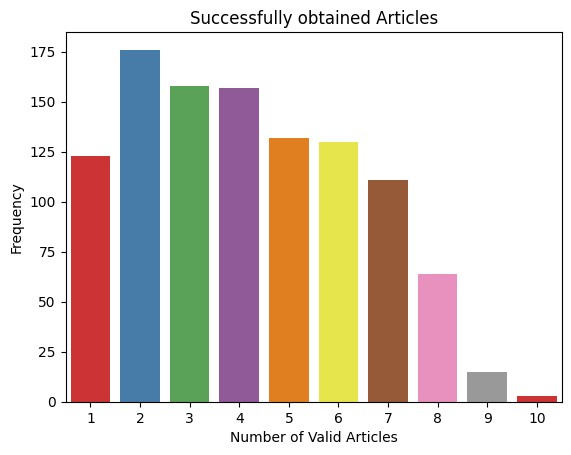

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

counts = df['num_valid_articles'].value_counts().reset_index()
counts.columns = ['Value', 'Count']  # Rename columns for clarity

# Create the barplot
sns.barplot(data=counts, x='Value', y='Count', palette='Set1')
plt.title('Successfully obtained Articles')
plt.xlabel('Number of Valid Articles')
plt.ylabel('Frequency')

# Article Stances

## Raw Stances

In [22]:
#try different transformation methods

def transform_stances(feat_dict, method):
    if pd.isna(feat_dict):
        return np.nan
    stance_list = feat_dict['article_stances']
    return method(stance_list)

### Mean

In [23]:
df['Stances_Mean'] = df['Features_Raw'].apply(lambda x: transform_stances(x, method=np.mean))

C:\Users\danie\AppData\Local\Temp\ipykernel_4064\1622541352.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Stances_Mean'] = df['Features_Raw'].apply(lambda x: transform_stances(x, method=np.mean))


In [24]:
df['Stances_Mean'].describe()

count    1069.000000
mean        0.175582
std         0.244435
min        -1.000000
25%         0.000000
50%         0.168000
75%         0.360000
max         1.000000
Name: Stances_Mean, dtype: float64

In [25]:
df.groupby('Category')['Stances_Mean'].describe()

,count,mean,std,min,25%,50%,75%,max
Category,,,,,,,,
Misl,374.0,0.092813,0.231392,-0.866667,-0.026667,0.056571,0.232500,0.76
True,695.0,0.220123,0.239774,-1.000000,0.058571,0.226667,0.409444,1.00


In [26]:
import pingouin as pg
pg.normality(data=df, dv='Stances_Mean', group='Category') #not normally distributed
pg.mwu(x=df.loc[df['Category'] == 'Misl', 'Stances_Mean'],
                y=df.loc[df['Category'] == 'True', 'Stances_Mean'],
                alternative='less') #Mann-Whitney U (testing if Misl (Group 1) is less than True (Group 2) -> differences statistically significant, but with a small effect size (RBC < 0.3)

,U-val,alternative,p-val,RBC,CLES
MWU,85933.5,less,2.867557e-20,-0.338795,0.669398


In [27]:
df.groupby('num_valid_articles')['Stances_Mean'].describe()

,count,mean,std,min,25%,50%,75%,max
num_valid_articles,,,,,,,,
1,123.0,0.151870,0.345689,-1.000000,0.000000,0.120000,0.440000,1.000000
2,176.0,0.161064,0.277457,-1.000000,0.000000,0.170000,0.400000,0.720000
3,158.0,0.150419,0.239744,-0.866667,0.000000,0.120000,0.318889,0.733333
4,157.0,0.132197,0.223240,-0.450000,-0.010000,0.100000,0.280000,0.630000
5,132.0,0.180452,0.198438,-0.272000,0.015333,0.168000,0.320000,0.576000
6,130.0,0.179735,0.207559,-0.460000,0.006667,0.203333,0.325000,0.600000
7,111.0,0.232545,0.198656,-0.342857,0.077778,0.240000,0.408571,0.566561
8,64.0,0.283025,0.160944,-0.070000,0.131250,0.292870,0.385000,0.670000
9,15.0,0.245037,0.158662,-0.031111,0.164444,0.275556,0.342222,0.475556


C:\Users\danie\AppData\Local\Temp\ipykernel_4064\2511394612.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Category', y='Stances_Mean', palette='Set1')


Text(0, 0.5, 'Stances Mean')

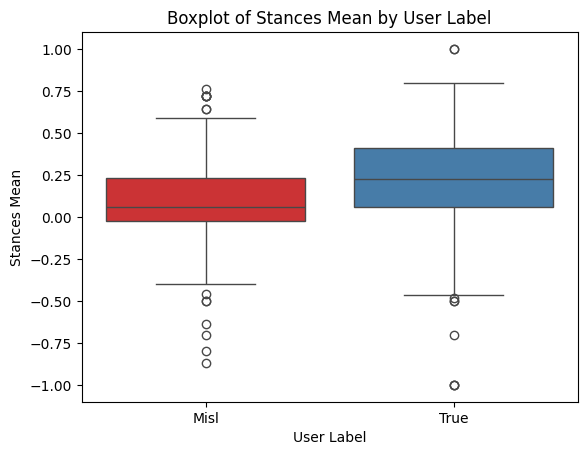

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.boxplot(data=df, x='Category', y='Stances_Mean', palette='Set1')
plt.title('Boxplot of Stances Mean by User Label')
plt.xlabel('User Label')
plt.ylabel('Stances Mean')

C:\Users\danie\AppData\Local\Temp\ipykernel_4064\3390867210.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='num_valid_articles', y='Stances_Mean', palette='Set1')


Text(0, 0.5, 'Stances Mean')

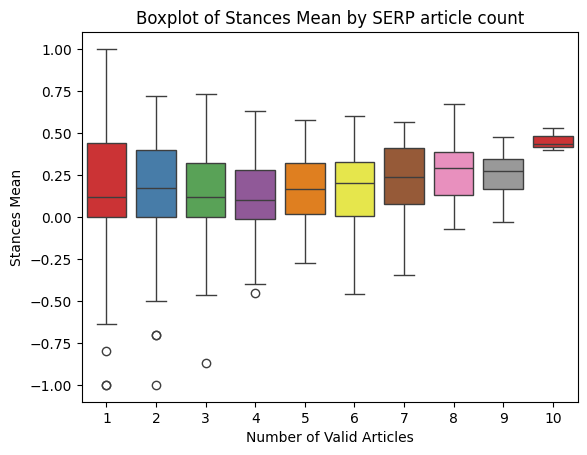

In [29]:
sns.boxplot(data=df, x='num_valid_articles', y='Stances_Mean', palette='Set1')
plt.title('Boxplot of Stances Mean by SERP article count')
plt.xlabel('Number of Valid Articles')
plt.ylabel('Stances Mean')

#### Last User Queries

In [30]:
last_search_df = df.drop_duplicates(subset='ResponseId', keep='last')
last_search_df.groupby('Category')['Stances_Mean'].describe()

,count,mean,std,min,25%,50%,75%,max
Category,,,,,,,,
Misl,78.0,0.09552,0.175251,-0.4,-0.026,0.0975,0.198333,0.525
True,279.0,0.24657,0.214195,-0.5,0.100,0.2400,0.420000,1.000


C:\Users\danie\AppData\Local\Temp\ipykernel_4064\3509361157.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=last_search_df, x='Category', y='Stances_Mean', palette='Set1')


Text(0, 0.5, 'Stances Mean')

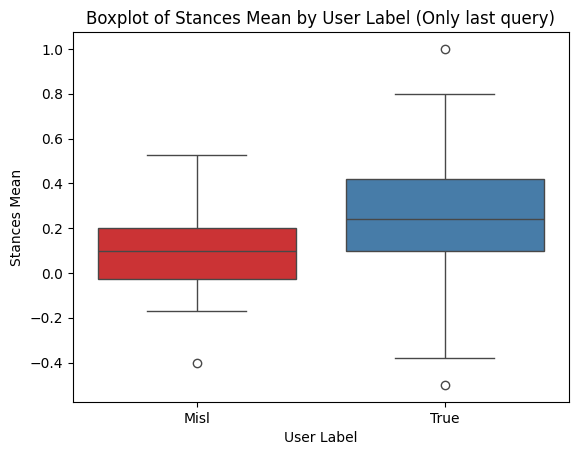

In [31]:
sns.boxplot(data=last_search_df, x='Category', y='Stances_Mean', palette='Set1')
plt.title('Boxplot of Stances Mean by User Label (Only last query)')
plt.xlabel('User Label')
plt.ylabel('Stances Mean')

### NDCG

In [32]:
from sklearn.metrics import ndcg_score

In [33]:
test_array = [0.5, 0.01, 0.3, -1, 1]

#transform values to fit between 0 and 1

def ndcg(stances):
    stances = np.array(stances)
    stances = (stances + 1) / 2  # Transform values from [-1, 1] to [0, 1]
    if len(stances) == 1:
        return np.nan
    true_relevance = np.array([stances])  
    relevance_score = np.array([sorted(stances, reverse=True)]) 
    print(true_relevance, relevance_score)

    return ndcg_score(true_relevance, relevance_score)
          
ndcg(test_array)

[[0.75  0.505 0.65  0.    1.   ]] [[1.    0.75  0.65  0.505 0.   ]]


np.float64(0.883307074205988)

In [34]:
df['Stances_NDCG'] = df['Features_Raw'].apply(lambda x: transform_stances(x, method=ndcg))

[[0.4  0.54 0.44 0.5 ]] [[0.54 0.5  0.44 0.4 ]]
[[0.62 0.7  0.56 0.7  0.6  0.5 ]] [[0.7  0.7  0.62 0.6  0.56 0.5 ]]
[[0.4  0.1  0.36 0.   0.16 0.6 ]] [[0.6  0.4  0.36 0.16 0.1  0.  ]]
[[0.58 0.42]] [[0.58 0.42]]
[[0.58       0.52       0.44642857 0.4       ]] [[0.58       0.52       0.44642857 0.4       ]]
[[0.58       0.52       0.44642857 0.4       ]] [[0.58       0.52       0.44642857 0.4       ]]
[[0.58 0.4  0.56]] [[0.58 0.56 0.4 ]]
[[0.58 0.4  0.56]] [[0.58 0.56 0.4 ]]
[[0.42 0.58]] [[0.58 0.42]]
[[0.42 0.5 ]] [[0.5  0.42]]
[[0.3  0.44 0.3  0.2  0.22 0.5  0.5 ]] [[0.5  0.5  0.44 0.3  0.3  0.22 0.2 ]]
[[0.42 0.5 ]] [[0.5  0.42]]
[[0.58 0.42]] [[0.58 0.42]]
[[0.42 0.5  0.38]] [[0.5  0.42 0.38]]
[[0.42 0.58 0.58]] [[0.58 0.58 0.42]]
[[0.4  0.38 0.4 ]] [[0.4  0.4  0.38]]
[[0.42 0.58]] [[0.58 0.42]]
[[0.42 0.52 0.62]] [[0.62 0.52 0.42]]
[[0.38 0.58]] [[0.58 0.38]]
[[0.2 0.5 0.5 0.3 0.5]] [[0.5 0.5 0.5 0.3 0.2]]
[[0.42 0.58 0.3 ]] [[0.58 0.42 0.3 ]]
[[0.5  0.7  0.42 0.4 ]] [[0.7  0.5  

C:\Users\danie\AppData\Local\Temp\ipykernel_4064\1914666279.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Stances_NDCG'] = df['Features_Raw'].apply(lambda x: transform_stances(x, method=ndcg))


In [35]:
df['Stances_NDCG'].describe()

count    937.000000
mean       0.961808
std        0.042928
min        0.630930
25%        0.942964
50%        0.970888
75%        0.994935
max        1.000000
Name: Stances_NDCG, dtype: float64

In [36]:
df.groupby('Category')['Stances_NDCG'].describe()

,count,mean,std,min,25%,50%,75%,max
Category,,,,,,,,
Misl,313.0,0.962000,0.047091,0.63093,0.942968,0.979006,1.000000,1.0
True,624.0,0.961712,0.040720,0.63093,0.942957,0.969104,0.992475,1.0


In [37]:
df.groupby('num_valid_articles')['Stances_NDCG'].describe()

,count,mean,std,min,25%,50%,75%,max
num_valid_articles,,,,,,,,
1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,167.0,0.979050,0.049443,0.630930,0.971989,1.000000,1.000000,1.000000
3,158.0,0.970380,0.044092,0.704431,0.956337,0.983427,1.000000,1.000000
4,157.0,0.961073,0.038604,0.768858,0.937206,0.972001,0.992628,1.000000
5,132.0,0.954630,0.046781,0.692736,0.935593,0.966428,0.987290,1.000000
6,130.0,0.955118,0.037223,0.801103,0.943023,0.962176,0.981172,1.000000
7,111.0,0.947774,0.037570,0.826093,0.929293,0.955874,0.976277,1.000000
8,64.0,0.954579,0.025890,0.844099,0.945001,0.959866,0.966138,1.000000
9,15.0,0.945686,0.032535,0.890233,0.921140,0.945426,0.975963,0.988966


C:\Users\danie\AppData\Local\Temp\ipykernel_4064\1980220825.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='num_valid_articles', y='Stances_NDCG', palette='Set1')


Text(0, 0.5, 'Stances Mean')

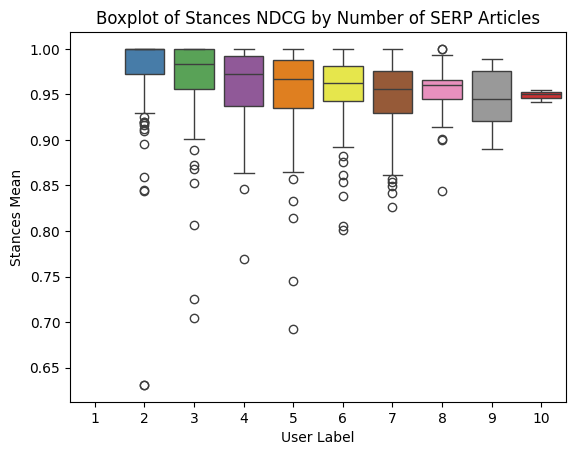

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.boxplot(data=df, x='num_valid_articles', y='Stances_NDCG', palette='Set1')
plt.title('Boxplot of Stances NDCG by Number of SERP Articles')
plt.xlabel('User Label')
plt.ylabel('Stances Mean')

### First vs. Last SERP Position

In [39]:
def retrieve_serp_results(feat_dict, position=1):
    if pd.isna(feat_dict):
        return np.nan
    
    stance_list = feat_dict['article_stances']
    serp_positions = feat_dict['article_serp_positions']
    
    if isinstance(position, list):
        results = [np.mean(stance_list[serp_positions.index(pos)]) for pos in position if pos in serp_positions]
        return np.nan if not results else np.mean(results)
    elif position in serp_positions:
        return np.mean(stance_list[serp_positions.index(position)])
    
    return np.nan

In [40]:
df['Stances_First'] = df['Features_Raw'].apply(lambda x: retrieve_serp_results(x, position=[1]))
df['Stances_Last'] = df['Features_Raw'].apply(lambda x: retrieve_serp_results(x, position=[10]))

C:\Users\danie\AppData\Local\Temp\ipykernel_4064\2326893941.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Stances_First'] = df['Features_Raw'].apply(lambda x: retrieve_serp_results(x, position=[1]))
C:\Users\danie\AppData\Local\Temp\ipykernel_4064\2326893941.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Stances_Last'] = df['Features_Raw'].apply(lambda x: retrieve_serp_results(x, position=[10]))


In [41]:
df['Stances_First'].describe()

count    499.000000
mean       0.198225
std        0.287728
min       -1.000000
25%        0.000000
50%        0.200000
75%        0.400000
max        1.000000
Name: Stances_First, dtype: float64

In [42]:
df['Stances_Last'].describe()

count    394.000000
mean       0.183934
std        0.270140
min       -0.600000
25%        0.000000
50%        0.160000
75%        0.360000
max        1.000000
Name: Stances_Last, dtype: float64

In [43]:
pg.normality(data=df['Stances_First']) #not normally distributed
# pg.mwu(x=df.loc[df['Category'] == 'Misl', 'avg_score'],
#                 y=df.loc[df['Category'] == 'True', 'avg_score'],
#                 alternative='greater') #Mann-Whitney U (testing if Misl (Group 1) is higher than True (Group 2) -> differences statistically significant, but with a small effect size (RBC < 0.3)

,W,pval,normal
Stances_First,0.94904,4.374249e-12,False


In [44]:
pg.normality(data=df['Stances_Last']) #not normally distributed

,W,pval,normal
Stances_Last,0.960769,9.226812e-09,False


In [45]:
#comparing last vs first against each other (not considering category)

In [93]:
pg.mwu(x=df['Stances_First'],
        y=df['Stances_Last'],
        alternative='greater') #Mann-Whitney U (testing if Misl (Group 1) is higher than True (Group 2) -> differences statistically significant, but with a small effect size (RBC < 0.3)

,U-val,alternative,p-val,RBC,CLES
MWU,106793.5,greater,0.013025,0.086371,0.543185


In [47]:
df.groupby('Category')['Stances_First'].describe()

,count,mean,std,min,25%,50%,75%,max
Category,,,,,,,,
Misl,163.0,0.129571,0.281296,-1.0,0.00,0.08,0.32,0.84
True,336.0,0.231530,0.285304,-1.0,0.08,0.28,0.40,1.00


In [ ]:
pg.normality(data=df, dv='Stances_First', group='Category') #not normally distributed
pg.mwu(x=df.loc[df['Category'] == 'Misl', 'Stances_First'],
                y=df.loc[df['Category'] == 'True', 'Stances_First'],
                alternative='less') #Mann-Whitney U test

,U-val,alternative,p-val,RBC,CLES
MWU,20625.5,less,0.000004,-0.246805,0.623402


In [49]:
df.groupby('Category')['Stances_Last'].describe()

,count,mean,std,min,25%,50%,75%,max
Category,,,,,,,,
Misl,115.0,0.088696,0.237164,-0.36,0.0,0.0,0.2,1.0
True,279.0,0.223189,0.273495,-0.60,0.0,0.2,0.4,1.0


In [50]:
pg.normality(data=df, dv='Stances_Last', group='Category') #not normally distributed
pg.mwu(x=df.loc[df['Category'] == 'Misl', 'Stances_Last'],
                y=df.loc[df['Category'] == 'True', 'Stances_Last'],
                alternative='less') #Mann-Whitney U (testing if Misl (Group 1) is higher than True (Group 2) -> differences statistically significant, but with a small effect size (RBC < 0.3)

,U-val,alternative,p-val,RBC,CLES
MWU,10985.5,less,3.582981e-07,-0.315225,0.657613


C:\Users\danie\AppData\Local\Temp\ipykernel_4064\4258603429.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Category', y='Stances_First', palette='Set1')


Text(0, 0.5, 'Stances Mean')

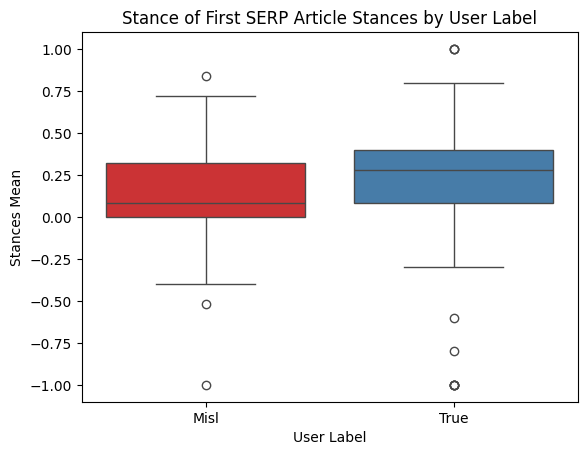

In [51]:
sns.boxplot(data=df, x='Category', y='Stances_First', palette='Set1')
plt.title('Stance of First SERP Article Stances by User Label')
plt.xlabel('User Label')
plt.ylabel('Stances Mean')

In [52]:
df['Stances_First'].describe()

count    499.000000
mean       0.198225
std        0.287728
min       -1.000000
25%        0.000000
50%        0.200000
75%        0.400000
max        1.000000
Name: Stances_First, dtype: float64

In [53]:
df['Stances_Last'].describe()

count    394.000000
mean       0.183934
std        0.270140
min       -0.600000
25%        0.000000
50%        0.160000
75%        0.360000
max        1.000000
Name: Stances_Last, dtype: float64

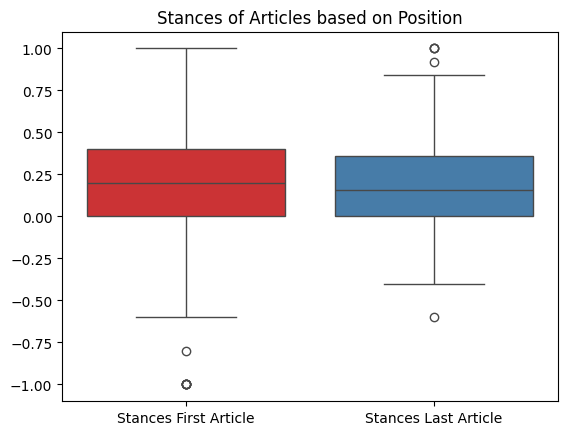

In [54]:
sns.boxplot(data=[df['Stances_First'], df['Stances_Last']], palette='Set1')
plt.title('Stances of Articles based on Position')
plt.xticks([0, 1], ['Stances First Article', 'Stances Last Article'])
plt.show()

In [55]:
df.groupby('Category')['Stances_Last'].describe()

,count,mean,std,min,25%,50%,75%,max
Category,,,,,,,,
Misl,115.0,0.088696,0.237164,-0.36,0.0,0.0,0.2,1.0
True,279.0,0.223189,0.273495,-0.60,0.0,0.2,0.4,1.0


C:\Users\danie\AppData\Local\Temp\ipykernel_4064\825327286.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Category', y='Stances_Last', palette='Set1')


Text(0, 0.5, 'Stances Mean')

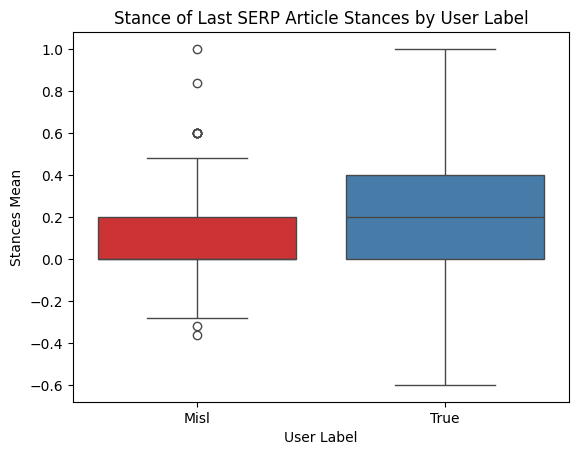

In [56]:
sns.boxplot(data=df, x='Category', y='Stances_Last', palette='Set1')
plt.title('Stance of Last SERP Article Stances by User Label')
plt.xlabel('User Label')
plt.ylabel('Stances Mean')

### Median

In [57]:
df['Stances_Median'] = df['Features_Raw'].apply(lambda x: transform_stances(x, method=np.median))

C:\Users\danie\AppData\Local\Temp\ipykernel_4064\614005084.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Stances_Median'] = df['Features_Raw'].apply(lambda x: transform_stances(x, method=np.median))


In [58]:
df['Stances_Median'].describe()

count    1069.000000
mean        0.182492
std         0.247744
min        -1.000000
25%         0.000000
50%         0.160000
75%         0.400000
max         1.000000
Name: Stances_Median, dtype: float64

In [59]:
df.groupby('Category')['Stances_Median'].describe()

,count,mean,std,min,25%,50%,75%,max
Category,,,,,,,,
Misl,374.0,0.096968,0.233927,-0.8,0.00,0.04,0.24,0.76
True,695.0,0.228514,0.242857,-1.0,0.04,0.22,0.42,1.00


In [60]:
df.groupby('num_valid_articles')['Stances_Median'].describe()

,count,mean,std,min,25%,50%,75%,max
num_valid_articles,,,,,,,,
1,123.0,0.151870,0.345689,-1.00,0.000,0.120000,0.440000,1.000
2,176.0,0.161064,0.277457,-1.00,0.000,0.170000,0.400000,0.720
3,158.0,0.162236,0.249804,-0.80,0.000,0.120000,0.320000,1.000
4,157.0,0.130606,0.225222,-0.40,0.000,0.080000,0.277241,0.645
5,132.0,0.190303,0.201543,-0.32,0.000,0.190000,0.320000,0.600
6,130.0,0.191536,0.208533,-0.48,0.020,0.180000,0.335000,0.620
7,111.0,0.251458,0.198908,-0.40,0.120,0.259259,0.400000,0.600
8,64.0,0.296192,0.165183,-0.04,0.175,0.293333,0.400000,0.640
9,15.0,0.240000,0.171047,-0.08,0.120,0.320000,0.360000,0.480


C:\Users\danie\AppData\Local\Temp\ipykernel_4064\2000799094.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Category', y='Stances_Median', palette='Set1')


Text(0, 0.5, 'Stances Median')

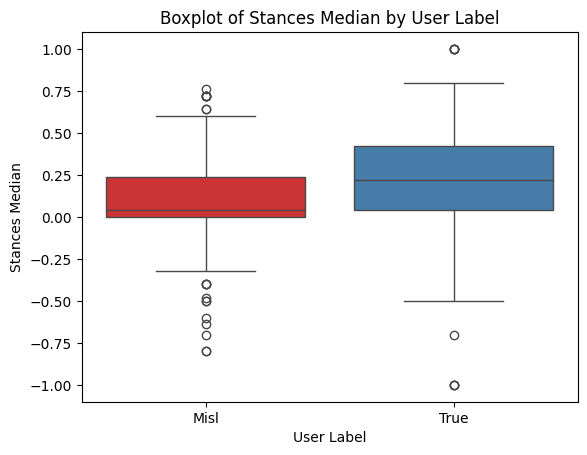

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.boxplot(data=df, x='Category', y='Stances_Median', palette='Set1')
plt.title('Boxplot of Stances Median by User Label')
plt.xlabel('User Label')
plt.ylabel('Stances Median')

## Stances w/ Positions

### Mean

In [62]:
df['Stances_Pos_Mean'] = df['Features_Pos'].apply(lambda x: transform_stances(x, method=np.mean))

C:\Users\danie\AppData\Local\Temp\ipykernel_4064\341998645.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Stances_Pos_Mean'] = df['Features_Pos'].apply(lambda x: transform_stances(x, method=np.mean))


In [63]:
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler(feature_range=(-1, 1))
# df['Stances_Pos_Mean'] = scaler.fit_transform(np.array(df['Stances_Pos_Mean']).reshape(-1, 1)).flatten()

In [64]:
df['Stances_Pos_Mean'].describe()

count    1069.000000
mean        0.180260
std         0.256042
min        -1.051961
25%         0.000000
50%         0.163802
75%         0.350860
max         1.311765
Name: Stances_Pos_Mean, dtype: float64

In [65]:
df.groupby('Category')['Stances_Pos_Mean'].describe()

,count,mean,std,min,25%,50%,75%,max
Category,,,,,,,,
Misl,374.0,0.087523,0.229235,-0.876371,-0.027177,0.050733,0.216872,0.872332
True,695.0,0.230165,0.255959,-1.051961,0.060508,0.236625,0.400810,1.311765


In [66]:
df.groupby('num_valid_articles')['Stances_Pos_Mean'].describe()


,count,mean,std,min,25%,50%,75%,max
num_valid_articles,,,,,,,,
1,123.0,0.153071,0.360251,-1.051961,0.000000,0.080000,0.424915,1.311765
2,176.0,0.157967,0.288559,-1.051961,0.000000,0.135396,0.359796,0.872332
3,158.0,0.141755,0.236629,-0.876371,0.000000,0.119064,0.284731,0.722187
4,157.0,0.142741,0.234026,-0.466434,-0.004653,0.084354,0.295690,0.708572
5,132.0,0.181280,0.212115,-0.310055,0.018288,0.168056,0.324739,0.684824
6,130.0,0.195146,0.222598,-0.559411,0.026335,0.213353,0.351901,0.741479
7,111.0,0.243949,0.210521,-0.366384,0.091836,0.243301,0.385738,0.659616
8,64.0,0.309231,0.187219,-0.061861,0.135550,0.338056,0.463101,0.789626
9,15.0,0.238765,0.155803,-0.026898,0.178027,0.255385,0.311914,0.543368


In [67]:
pg.normality(data=df, dv='Stances_Pos_Mean', group='Category') #not normally distributed
pg.mwu(x=df.loc[df['Category'] == 'Misl', 'Stances_Pos_Mean'],
                y=df.loc[df['Category'] == 'True', 'Stances_Pos_Mean'],
                alternative='less')

,U-val,alternative,p-val,RBC,CLES
MWU,82498.0,less,3.049764e-23,-0.365229,0.682615


C:\Users\danie\AppData\Local\Temp\ipykernel_4064\4211040222.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Category', y='Stances_Pos_Mean', palette='Set1')


Text(0, 0.5, 'Stances Mean')

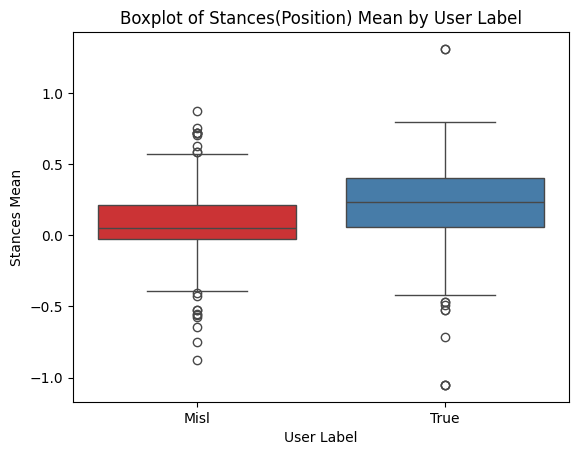

In [68]:
sns.boxplot(data=df, x='Category', y='Stances_Pos_Mean', palette='Set1')
plt.title('Boxplot of Stances(Position) Mean by User Label')
plt.xlabel('User Label')
plt.ylabel('Stances Mean')

In [69]:
last_search_df = df.drop_duplicates(subset='ResponseId', keep='last')
last_search_df.groupby('Category')['Stances_Pos_Mean'].describe()

,count,mean,std,min,25%,50%,75%,max
Category,,,,,,,,
Misl,78.0,0.092817,0.170544,-0.391879,-0.016860,0.079012,0.152736,0.571149
True,279.0,0.250085,0.228105,-0.525980,0.097568,0.244855,0.389894,1.311765


## Stances w/ Headlines

### Mean

In [70]:
df['Stances_H_Mean'] = df['Features_H'].apply(lambda x: transform_stances(x, method=np.mean))

C:\Users\danie\AppData\Local\Temp\ipykernel_4064\2604616633.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Stances_H_Mean'] = df['Features_H'].apply(lambda x: transform_stances(x, method=np.mean))


In [71]:
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler(feature_range=(-1, 1))
# df['Stances_H_Mean'] = scaler.fit_transform(np.array(df['Stances_H_Mean']).reshape(-1, 1)).flatten()

In [72]:
df['Stances_H_Mean'].describe()

count    1069.000000
mean        0.019979
std         0.069480
min        -0.300000
25%         0.000000
50%         0.000000
75%         0.026667
max         1.000000
Name: Stances_H_Mean, dtype: float64

In [73]:
df.groupby('Category')['Stances_H_Mean'].describe()

,count,mean,std,min,25%,50%,75%,max
Category,,,,,,,,
Misl,374.0,0.012086,0.059280,-0.173333,0.0,0.0,0.015333,0.52
True,695.0,0.024226,0.074085,-0.300000,0.0,0.0,0.030000,1.00


In [74]:
import pingouin as pg
pg.normality(data=df, dv='Stances_H_Mean', group='Category') #not normally distributed
pg.mwu(x=df.loc[df['Category'] == 'Misl', 'Stances_H_Mean'],
                y=df.loc[df['Category'] == 'True', 'Stances_H_Mean'],
                alternative='less') #Mann-Whitney U (testing if Misl (Group 1) is less than True (Group 2) -> differences statistically significant, but with a small effect size (RBC < 0.3)

,U-val,alternative,p-val,RBC,CLES
MWU,107609.0,less,3.115681e-07,-0.172016,0.586008


In [75]:
df.groupby('num_valid_articles')['Stances_H_Mean'].describe()

,count,mean,std,min,25%,50%,75%,max
num_valid_articles,,,,,,,,
1,123.0,0.023740,0.136642,-0.200000,0.000,0.000000,0.000000,1.000000
2,176.0,0.023523,0.085277,-0.300000,0.000,0.000000,0.020000,0.520000
3,158.0,0.010070,0.041452,-0.066667,0.000,0.000000,0.013333,0.333333
4,157.0,0.021746,0.056136,-0.050000,0.000,0.000000,0.030000,0.300000
5,132.0,0.016646,0.043262,-0.080000,0.000,0.000000,0.032000,0.264000
6,130.0,0.020121,0.041185,-0.173333,0.000,0.000000,0.033333,0.160000
7,111.0,0.022367,0.043614,-0.057143,0.000,0.011429,0.034286,0.225714
8,64.0,0.024070,0.045760,-0.025000,0.000,0.018141,0.030000,0.212500
9,15.0,0.026667,0.032005,-0.008889,0.000,0.022222,0.042222,0.088889


C:\Users\danie\AppData\Local\Temp\ipykernel_4064\3702187806.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Category', y='Stances_H_Mean', palette='Set1')


Text(0, 0.5, 'Stances Mean')

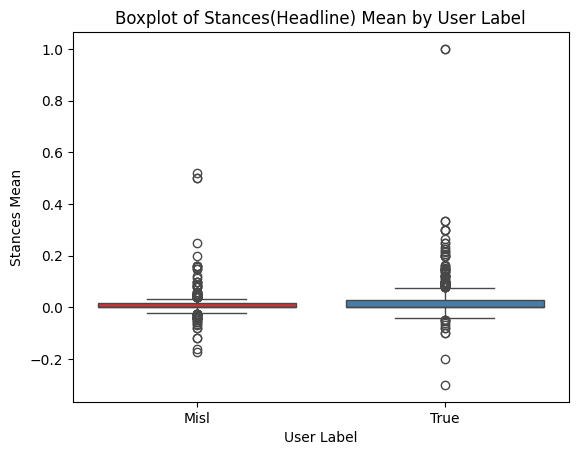

In [76]:
sns.boxplot(data=df, x='Category', y='Stances_H_Mean', palette='Set1')
plt.title('Boxplot of Stances(Headline) Mean by User Label')
plt.xlabel('User Label')
plt.ylabel('Stances Mean')

## Stances w/ Headlines and Pos

In [77]:
df['Stances_HP_Mean'] = df['Features_HP'].apply(lambda x: transform_stances(x, method=np.mean))

C:\Users\danie\AppData\Local\Temp\ipykernel_4064\2275436934.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Stances_HP_Mean'] = df['Features_HP'].apply(lambda x: transform_stances(x, method=np.mean))


In [78]:
df['Stances_HP_Mean'].describe()

count    1069.000000
mean        0.201961
std         0.299219
min        -1.051961
25%         0.000000
50%         0.186087
75%         0.380602
max         2.623529
Name: Stances_HP_Mean, dtype: float64

In [79]:
df.groupby('Category')['Stances_HP_Mean'].describe()

,count,mean,std,min,25%,50%,75%,max
Category,,,,,,,,
Misl,374.0,0.099210,0.266844,-0.956641,-0.028632,0.055935,0.232555,1.546845
True,695.0,0.257254,0.301262,-1.051961,0.064661,0.258051,0.467215,2.623529


In [80]:
df.groupby('num_valid_articles')['Stances_HP_Mean'].describe()

,count,mean,std,min,25%,50%,75%,max
num_valid_articles,,,,,,,,
1,123.0,0.182183,0.468849,-1.051961,0.000000,0.091667,0.391847,2.623529
2,176.0,0.182409,0.340236,-1.051961,0.000000,0.168270,0.377511,1.546845
3,158.0,0.147804,0.248135,-0.956641,0.000000,0.132555,0.306783,0.722187
4,157.0,0.167859,0.267499,-0.466434,-0.004653,0.112929,0.310015,0.980585
5,132.0,0.198540,0.237770,-0.310055,0.015338,0.184998,0.359997,0.684824
6,130.0,0.220223,0.254081,-0.795390,0.021955,0.246735,0.386887,0.841438
7,111.0,0.268418,0.235173,-0.400785,0.081074,0.279999,0.452193,0.659616
8,64.0,0.333961,0.204999,-0.061861,0.144438,0.363396,0.503307,0.789626
9,15.0,0.272886,0.175360,-0.002417,0.217491,0.259189,0.413143,0.589088


In [81]:
pg.normality(data=df, dv='Stances_HP_Mean', group='Category') #not normally distributed
pg.mwu(x=df.loc[df['Category'] == 'Misl', 'Stances_HP_Mean'],
                y=df.loc[df['Category'] == 'True', 'Stances_HP_Mean'],
                alternative='less')

,U-val,alternative,p-val,RBC,CLES
MWU,82649.5,less,4.170810e-23,-0.364063,0.682032


C:\Users\danie\AppData\Local\Temp\ipykernel_4064\1375276248.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Category', y='Stances_HP_Mean', palette='Set1')


Text(0, 0.5, 'Stances Mean')

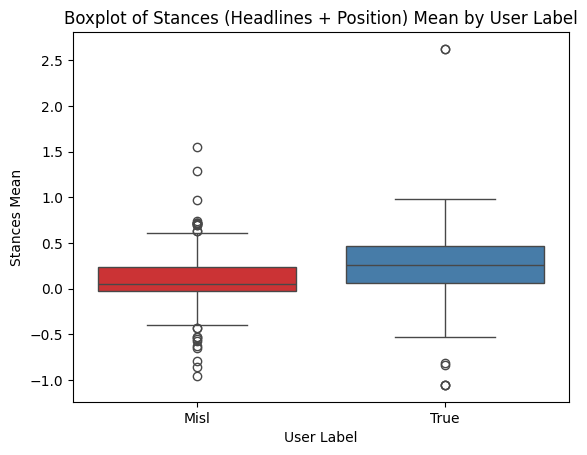

In [82]:
sns.boxplot(data=df, x='Category', y='Stances_HP_Mean', palette='Set1')
plt.title('Boxplot of Stances (Headlines + Position) Mean by User Label')
plt.xlabel('User Label')
plt.ylabel('Stances Mean')

# Newsguard Score

In [83]:
def transform_newsguard(feat_dict, method):
    if pd.isna(feat_dict):
        return np.nan
    article_ng_scores = feat_dict['article_ng_scores']
    article_ng_scores = np.nan_to_num(article_ng_scores, nan=0)
    return method(article_ng_scores)

In [84]:
df['Newsguard_Mean'] = df['Features_Raw'].apply(lambda x: transform_newsguard(x, method=np.mean))

C:\Users\danie\AppData\Local\Temp\ipykernel_4064\1875328657.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Newsguard_Mean'] = df['Features_Raw'].apply(lambda x: transform_newsguard(x, method=np.mean))


In [85]:
df.groupby('Category')['avg_score'].describe()

,count,mean,std,min,25%,50%,75%,max
Category,,,,,,,,
Misl,374.0,87.829194,12.457337,23.5,87.152597,92.035714,94.722222,100.0
True,692.0,88.307306,11.642760,5.0,86.875000,91.414286,94.500000,100.0


In [86]:
pg.normality(data=df, dv='avg_score', group='Category') #not normally distributed
# pg.mwu(x=df.loc[df['Category'] == 'Misl', 'avg_score'],
#                 y=df.loc[df['Category'] == 'True', 'avg_score'],
#                 alternative='greater') #Mann-Whitney U (testing if Misl (Group 1) is higher than True (Group 2) -> differences statistically significant, but with a small effect size (RBC < 0.3)

,W,pval,normal
Category,,,
Misl,0.712484,7.550276e-25,False
True,0.697911,2.121455e-33,False


This is the NewsGuard Score of the retrieved articles. For the final calculation, we instead use the average NG score given above.

C:\Users\danie\AppData\Local\Temp\ipykernel_4064\3465771059.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Category', y='Newsguard_Mean', palette='Set2')


Text(0, 0.5, 'NG Mean')

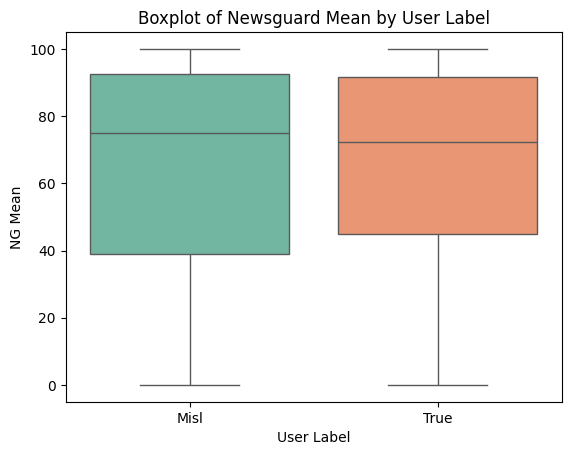

In [87]:
sns.boxplot(data=df, x='Category', y='Newsguard_Mean', palette='Set2')
plt.title('Boxplot of Newsguard Mean by User Label')
plt.xlabel('User Label')
plt.ylabel('NG Mean')

# Article SERP Position

## Mean Rank

In [88]:
def transform_serp_position(feat_dict, method):
    if pd.isna(feat_dict):
        return np.nan
    article_serp_positions = feat_dict['article_serp_positions']
    article_serp_positions = np.nan_to_num(article_serp_positions, nan=0)
    return method(article_serp_positions)

In [89]:
df['SERP_Position_Mean'] = df['Features_Raw'].apply(lambda x: transform_serp_position(x, method=np.mean))

C:\Users\danie\AppData\Local\Temp\ipykernel_4064\3830219677.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SERP_Position_Mean'] = df['Features_Raw'].apply(lambda x: transform_serp_position(x, method=np.mean))


In [90]:
df.groupby('Category')['SERP_Position_Mean'].describe()

,count,mean,std,min,25%,50%,75%,max
Category,,,,,,,,
Misl,374.0,5.262378,1.884809,1.0,4.000000,5.225,6.333333,10.0
True,695.0,5.134013,1.660343,1.0,4.333333,5.250,6.000000,10.0


C:\Users\danie\AppData\Local\Temp\ipykernel_4064\3667827325.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Category', y='SERP_Position_Mean', palette='Set3')


Text(0, 0.5, 'NG Mean')

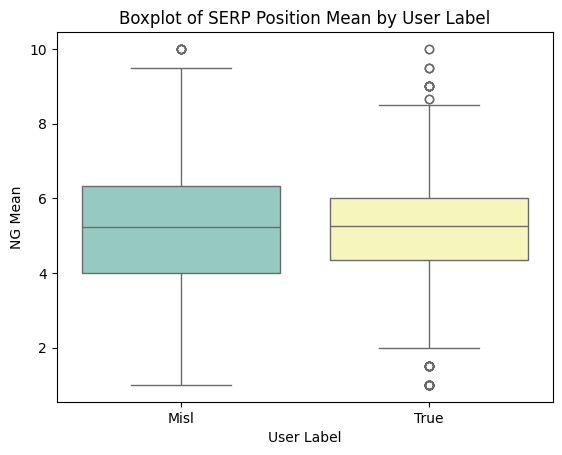

In [91]:
sns.boxplot(data=df, x='Category', y='SERP_Position_Mean', palette='Set3')
plt.title('Boxplot of SERP Position Mean by User Label')
plt.xlabel('User Label')
plt.ylabel('NG Mean')